# PyMC Wrapper

> Wrapper to unify the generation of pymc marketing priors

In [ ]:
#| default_exp wrapper/pymc_wrapper

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.test import *

In [ ]:
#| export
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Protocol, Callable, Tuple

import numpy as np
import xarray as xr
import pymc as pm
import pytensor.tensor as pt
from pymc_marketing.prior import handle_dims
from pymc_marketing.prior import (Prior as _Prior, register_tensor_transform)
from pymc_marketing.mmm.hsgp import (
    HSGP as _HSGP, 
    HSGPPeriodic as _HSGPPeriodic
)
from pymc_marketing.mmm.fourier import (
    WeeklyFourier as _WeeklyFourier,
    MonthlyFourier as _MonthlyFourier,
    YearlyFourier as _YearlyFourier
)


In [ ]:
#| export
class _GeneralPrior(ABC):
    """Generalized prior interface for pymc-marketing. This generalizes the use of the apply method to any prior.
    """
    def __init__(
        self, 
        name: str, 
        **kwargs
        ):
        self.name = name
        self._variable = None

    @abstractmethod
    def _apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        """Apply the prior to the data. This is an abstract method that must be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement _apply method.")
    
    def apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        """Apply the prior to the data. This method is a wrapper around the _apply method."""

        if self._variable is None:
            self._variable = self._apply(data, model)

        return self._variable

    
    def transform(
        self,
        transform: Callable,
    ) -> _TransformPrior:
        """Transform the prior using a callable function."""
        return _TransformPrior(
            self,
            transform
        )

    def __add__(
        self, 
        other: _GeneralPrior
        ) -> _SumPrior:
        return _SumPrior(
            [
                self, 
                other
            ], 
            name=f"({self.name}+{other.name})"
        )

    def __mul__(
        self, 
        other: _GeneralPrior
        ) -> _ProductPrior:
        return _ProductPrior(
            [
                self, 
                other
            ], 
            name=f"({self.name}*{other.name})")

    def __truediv__(self, other: _GeneralPrior) -> _DivPrior:
        return _DivPrior(
            numerator=self,
            denominator=other,
            name=f"({self.name}/{other.name})"
        )

    def __call__(
        self, 
        node: _GeneralPrior
        ) -> _GeneralPrior:
        return _AppliedPrior(
            f"({self.name}({node.name}))", 
            self, 
            node
        )


In [ ]:
#| export
class _TransformPrior(_GeneralPrior):
    """Transform the prior using a callable function."""
    def __init__(
        self, 
        prior: _GeneralPrior, # Prior to be transformed
        transform: Callable # Callable function to transform the prior
        ) -> None:
        """Initialize the transform prior."""
        super().__init__(prior.name)
        self.prior = prior
        self.transform = transform
        self._dims = prior._dims

    def _apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        """Apply the prior to the data and transform it using the callable function."""
        model = pm.modelcontext(model)

        with model:
            return self.transform(self.prior.apply(data))

In [ ]:
#| export
class _CombPrior(_GeneralPrior):
    def __init__(
        self, 
        children: list[GeneralPrior], 
        name: str, 
        agg_fn: Callable
        ):
        super().__init__(name)
        self.children = children
        self.agg_fn = agg_fn
        self._dims = tuple(
            set(
                dim for dims in [child._dims for child in self.children] for dim in dims
            )
        )
    def _process_children(self):
        flattened_children = []
        for child in self.children:
            if isinstance(child, _CombPrior):
                flattened_children.extend(child._process_children())
            else:
                flattened_children.append(child)
        return flattened_children

    def _apply(
        self, 
        data: xr.DataArray | pt.TensorLike, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        
        with model:
            children = self._process_children()
            
            for _child in (children):
                _child.apply(data)
            self._variable = (
                self.agg_fn(
                    [
                        handle_dims(child._variable, child._dims, self._dims)
                        for child in children
                    ]
                ))
        return self._variable

In [ ]:
#| export
class _DivPrior(_GeneralPrior):
    def __init__(
        self, 
        numerator: _GeneralPrior, 
        denominator: _GeneralPrior, 
        name: str
        ):
        super().__init__(name)
        self.numerator = numerator
        self.denominator = denominator
        self._dims = tuple(
            set(
                dim for dims in [numerator._dims, denominator._dims] for dim in dims
            )
        )

    def _apply(
        self, 
        data: xr.DataArray | pt.TensorLike, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)

        with model:
            num = self.numerator.apply(data)
            dem = self.denominator.apply(data)

            numerator = handle_dims(num, self.numerator._dims, self._dims)
            denominator = handle_dims(dem, self.denominator._dims, self._dims)
            self._variable = numerator / denominator
            
            return self._variable

In [ ]:
#| export
class _SumPrior(_CombPrior):
    def __init__(
        self, 
        children: list[_GeneralPrior], 
        name: str
        ):
        super().__init__(children, name, sum)

In [ ]:
#| export
class _ProductPrior(_CombPrior):
    def __init__(
        self, 
        children: list[_GeneralPrior], 
        name: str
        ):
        super().__init__(children, name, np.prod)

In [ ]:
#| export
class _AppliedPrior(_GeneralPrior):
    def __init__(
        self, 
        name: str, 
        caller_node: _GeneralPrior, 
        input_node: _GeneralPrior
        ):
        super().__init__(name)
        self._caller_node = caller_node
        self._input_node = input_node
        self._dims = caller_node._dims

    def _apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)

        with model: 
            self._variable = self._caller_node.apply(self._input_node.apply(data), model=model)
        
        return self._variable

In [ ]:
#| export
class HSGP(_GeneralPrior):
    def __init__(
        self, 
        name: str,
        **kwargs
        ):
        super().__init__(name)
        self._gp = _HSGP(**kwargs)
        self._dims = self._gp.dims
        
    
    def __getattr__(self, name: str):
        if hasattr(self._gp, name):
            return getattr(self._gp, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def _apply(
        self,
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._gp.register_data(data).create_variable(self.name)
        return self._variable

In [ ]:
hspg = HSGP(
    "hspg",
    m=40,
    ls=1,
    eta=3,
    L=60,
    dims=("date",)
)

In [ ]:
#| export
class HSGPPeriodic(_GeneralPrior):
    def __init__(
        self, 
        name: str,
        **kwargs
        ):
        super().__init__(name)
        self._gp = _HSGPPeriodic(**kwargs)
        self._dims = self._gp.dims
        
    
    def __getattr__(self, name: str):
        if hasattr(self._gp, name):
            return getattr(self._gp, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def _apply(
        self,
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._gp.register_data(data).create_variable(self.name)
        return self._variable

In [ ]:
#| export
class YearlyFourier(_GeneralPrior):
    def __init__(self, name: str, **kwargs):
        super().__init__(name)
        kwargs |= {'prefix': name}
        self._fourier = _YearlyFourier(**kwargs)
        self._dims = kwargs.get("dims", ("date",))

    def __getattr__(self, name: str):
        if hasattr(self._fourier, name):
            return getattr(self._fourier, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
    
    def _apply(
        self, data: xr.DataArray | pt.TensorLike | None, model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = pm.Deterministic(
                self.name, self._fourier.apply(data), dims=self._dims
            )
        return self._variable

In [ ]:
yearly_fourier = YearlyFourier(
    name="yearly_fourier",
    n_order=3,
    dims=("date",),
)

In [ ]:
#| eval: false
#| output: asis
show_doc(yearly_fourier.sample_prior)

---

### FourierBase.sample_prior

>      FourierBase.sample_prior (coords:dict|None=None, **kwargs)

*Sample the prior distributions.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| coords | dict \| None | None | Coordinates for the prior distribution, by default None |
| kwargs | VAR_KEYWORD |  | Additional keywords for sample_prior_predictive |
| **Returns** | **Dataset** |  | **Prior distribution.** |

In [ ]:
#| eval: false
#| output: asis
show_doc(yearly_fourier.sample_curve)

---

### FourierBase.sample_curve

>      FourierBase.sample_curve (parameters:arviz.data.inference_data.InferenceD
>                                ata|xarray.core.dataset.Dataset,
>                                use_dates:bool=False,
>                                start_date:str|datetime.datetime|None=None)

*Create full period of the Fourier seasonality.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| parameters | arviz.data.inference_data.InferenceData \| xarray.core.dataset.Dataset |  | Inference data or dataset containing the Fourier parameters.<br>Can be posterior or prior. |
| use_dates | bool | False | If True, use datetime coordinates for the x-axis. Defaults to False. |
| start_date | str \| datetime.datetime \| None | None | Starting date for the Fourier curve. If not provided and use_dates is True,<br>it will be derived from the current year or month. Defaults to None. |
| **Returns** | **DataArray** |  | **Full period of the Fourier seasonality.** |

Sampling: [yearly_fourier_beta]
Sampling: []


Output()

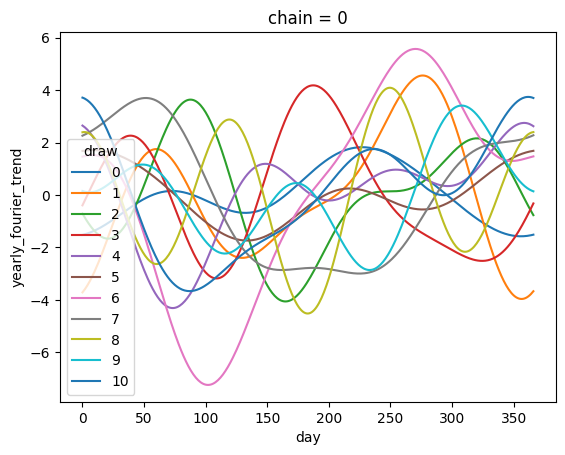

In [ ]:
prior_sample = yearly_fourier.sample_prior(coords={"date": np.arange(0, 365)})
curve_sample = yearly_fourier.sample_curve(prior_sample)
curve_sample.sel(chain=0, draw=slice(10)).plot(x='day', hue='draw');

In [ ]:
#| export
class WeeklyFourier(_GeneralPrior):
    def __init__(self, name: str, **kwargs):
        super().__init__(name)
        kwargs |= {'prefix': name}
        self._fourier = _WeeklyFourier(**kwargs)
        self._dims = kwargs.get("dims", ("date",))

    def __getattr__(self, name: str):
        if hasattr(self._fourier, name):
            return getattr(self._fourier, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
    
    def _apply(
        self, data: xr.DataArray | pt.TensorLike | None, model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = pm.Deterministic(
                self.name, self._fourier.apply(data), dims=self._dims
            )
        return self._variable

In [ ]:
#| export
class Prior(_GeneralPrior):
    __class__ = _Prior
    def __init__(self, name: str, **kwargs):
        super().__init__(name)
        prior_name = kwargs.pop("prior_name", None)
        self._prior = _Prior(prior_name, **kwargs)
        self._dims = self._prior.dims

    def _apply(
        self,
        data: xr.DataArray | pt.TensorLike | None = None,
        model: pm.Model | None = None,
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._prior.create_variable(self.name)
        return self._variable

    def __getattr__(self, name: str):
        if hasattr(self._prior, name):
            return getattr(self._prior, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

In [ ]:
#| export
class Data(_GeneralPrior):
    def __init__(self, name: str, dims: Tuple[str] | None = None):
        super().__init__(name)
        self._dims = dims

    def _apply(
        self, data: xr.DataArray | pt.TensorLike, model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        
        with model:
            self._variable = pm.Data(self.name, data, dims=self._dims)
        return self._variable

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()